In [1]:
%matplotlib inline
import pandas as pd
import pylab as p
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import time
from multiprocessing import Pool
from scipy.stats import boxcox
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
core_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/CORE.csv')
game_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/GAMES.csv')
player_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PLAYERS.csv', index_col=[0])
team_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/TEAM.csv', index_col=[0])
plays_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/CORE.csv', index_col=[1])
pass_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PASS.csv', index_col=[0])
rush_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/RUSH.csv', index_col=[0])
pass_df = pass_df.join(plays_df)
rush_df = rush_df.join(plays_df)
conv_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/CONVS.csv', index_col=[0])
conv_df = conv_df.join(plays_df['GID'])
kickoff_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/KICKOFFS.csv', index_col=[0])
kickoff_df = kickoff_df.join(plays_df)

punt_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PUNTS.csv', index_col=[0])
punt_df = punt_df.join(plays_df)
tackle_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/TACKLES.csv', index_col=[0])
intercept_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/INTS.csv', index_col=[0])
fumble_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/FUMBLES.csv', index_col=[0])
tackle_df = tackle_df.join(plays_df)
intercept_df = intercept_df.join(plays_df)
fumble_df = fumble_df.join(plays_df)

In [3]:
#win_orig_df = win_orig_df.join(game_df)
offense_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/OFFENSE.csv', index_col=[2])
offense_df['PLAYER'] = offense_df.index
defense_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/DEFENSE.csv', index_col=[2])
defense_df['PLAYER'] = defense_df.index
players_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PLAYERS.csv', index_col=[0])
offense_df = offense_df.join(players_df['POS1'])
offense_df = offense_df.rename(columns={'POS1':'POS'})
offense_df.set_index('GID', inplace=True)
offense_df = offense_df.join(game_df['OU'])
offense_df = offense_df.join(game_df['SPRV'])
offense_df['GID'] = offense_df.index
offense_df.set_index('PLAYER', inplace=True)
offense_df['PLAYER'] = offense_df.index
defense_df = defense_df.join(players_df['POS1'])
defense_df = defense_df.rename(columns={'POS1':'POS'})

players_df['player_id'] = players_df.index
# offense_df = offense_df.join(players_df)
# defense_df = defense_df.join(players_df)

In [4]:
pass_groups = pass_df.groupby(['GID', 'PSR']) 
snp_list = []
for name, group in pass_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "PASSER_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
offense_df = pd.merge(offense_df, snp_df, how='left', on=['GID', 'PLAYER'])

pass_groups = pass_df.groupby(['GID', 'TRG']) 
snp_list = []
for name, group in pass_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "TRG_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
offense_df = pd.merge(offense_df, snp_df, how='left', on=['GID', 'PLAYER'])

rush_groups = rush_df.groupby(['GID', 'BC']) 
snp_list = []
for name, group in rush_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "BC_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
offense_df = pd.merge(offense_df, snp_df, how='left', on=['GID', 'PLAYER'])

fumble_groups = fumble_df.groupby(['GID', 'FRCV'])
fumble_list = []
for name, group in fumble_groups:
    fumble_list.append({"GID":name[0], "PLAYER":name[1], "FRCV":len(group)})
fumble_rcv_df = pd.DataFrame(fumble_list)
fumble_rcv_df = fumble_rcv_df.fillna(0)
offense_df = pd.merge(offense_df, fumble_rcv_df, how='left', on=['GID', 'PLAYER'])

run_conv_groups = conv_df[conv_df['CONV'] == 'Y'].groupby(['GID', 'BC'])
run_conv_list = []
for name, group in run_conv_groups:
    run_conv_list.append({"GID":name[0], "PLAYER":name[1], "2PTCONV_BC":len(group)})
run_conv_df = pd.DataFrame(run_conv_list)
run_conv_df = run_conv_df.fillna(0)
offense_df = pd.merge(offense_df, run_conv_df, how='left', on=['GID', 'PLAYER'])


passer_conv_groups = conv_df[conv_df['CONV'] == 'Y'].groupby(['GID', 'PSR'])
passer_conv_list = []
for name, group in passer_conv_groups:
    passer_conv_list.append({"GID":name[0], "PLAYER":name[1], "2PTCONV_PSR":len(group)})
passer_conv_df = pd.DataFrame(passer_conv_list)
passer_conv_df = passer_conv_df.fillna(0)
offense_df = pd.merge(offense_df, passer_conv_df, how='left', on=['GID', 'PLAYER'])

passertrg_conv_groups = conv_df[conv_df['CONV'] == 'Y'].groupby(['GID', 'TRG'])
passertrg_conv_list = []
for name, group in passertrg_conv_groups:
    passertrg_conv_list.append({"GID":name[0], "PLAYER":name[1], "2PTCONV_TRG":len(group)})
passertrg_conv_df = pd.DataFrame(passertrg_conv_list)
passertrg_conv_df = passertrg_conv_df.fillna(0)
offense_df = pd.merge(offense_df, passertrg_conv_df, how='left', on=['GID', 'PLAYER'])

punt_groups = punt_df[punt_df['PTSO'] == 6].groupby(['GID', 'PR'])
punt_list = []
for name, group in punt_groups:
    punt_list.append({"GID":name[0], "PLAYER":name[1], "PUNT_TDRET":len(group)})
punt_df = pd.DataFrame(punt_list)
punt_df = punt_df.fillna(0)
offense_df = pd.merge(offense_df, punt_df, how='left', on=['GID', 'PLAYER'])

kickoff_groups = kickoff_df[kickoff_df['PTSO'] == 6].groupby(['GID', 'KR'])
kickoff_list = []
for name, group in kickoff_groups:
    kickoff_list.append({"GID":name[0], "PLAYER":name[1], "KICKOFF_TDRET":len(group)})
kickoff_df = pd.DataFrame(kickoff_list)
kickoff_df = kickoff_df.fillna(0)
offense_df = pd.merge(offense_df, kickoff_df, how='left', on=['GID', 'PLAYER'])

offense_df['TDRET'] = offense_df['PUNT_TDRET'] + offense_df['KICKOFF_TDRET']

offense_df['2PTCONV'] = offense_df['2PTCONV_BC'] + offense_df['2PTCONV_PSR'] + offense_df['2PTCONV_TRG']

offense_df['SNP'] = offense_df['BC_SNP'] + offense_df['TRG_SNP'] +offense_df['PASSER_SNP']


In [5]:
tackle_groups = tackle_df.groupby(['GID', 'TCK']) 
snp_list = []
for name, group in tackle_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "TACKLE_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
defense_df = pd.merge(defense_df, snp_df, how='left', on=['GID', 'PLAYER'])

intercept_groups = intercept_df.groupby(['GID', 'INT']) 
snp_list = []
for name, group in intercept_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "INTERCEPT_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
defense_df = pd.merge(defense_df, snp_df, how='left', on=['GID', 'PLAYER'])

fumble_groups = fumble_df.groupby(['GID', 'FRCV']) 
snp_list = []
for name, group in fumble_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "FUMBLE_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
defense_df = pd.merge(defense_df, snp_df, how='left', on=['GID', 'PLAYER'])

defense_df['SNP'] = defense_df['TACKLE_SNP'] + defense_df['INTERCEPT_SNP'] + defense_df['FUMBLE_SNP']

In [6]:
def draft_kings_score(row):
    score = (row['TDP']*4.0) + (row['PY']*0.04) + (3 * (1.0 if row['PY'] > 300 else 0.0)) 
    score += (-1*row['INT']) + (0.1*row['RY']) + (6.0*row['TDR']) 
    score += (3*(1.0 if row['RY'] > 100 else 0.0)) + (0.1 * row['RECY']) + (1 * row['REC']) + (6 * row['TDRE'])
    score += (3 *(1.0 if row['RECY'] > 100 else 0.0))
#     score += (6 * row['TDRET']) + (-1 * row['FUML']) + (6 * row['FRCV']) + (2 * row['2PTCONV']) 
    return score

offense_df['GID_tmp'] = offense_df['GID']
offense_df['TEAM_tmp'] = offense_df['TEAM']
offense_df = offense_df.set_index(['GID', 'TEAM'])
offense_df['GID'] = offense_df['GID_tmp']
offense_df['TEAM'] = offense_df['TEAM_tmp']

offense_df = offense_df.fillna(0.0)

offense_df['dk_fpts'] = offense_df.apply(lambda row:  draft_kings_score(row), axis=1)


defense_df['GID_tmp'] = defense_df['GID']
defense_df['TEAM_tmp'] = defense_df['TEAM']
defense_df = defense_df.set_index(['GID', 'TEAM'])
defense_df['GID'] = defense_df['GID_tmp']
defense_df['TEAM'] = defense_df['TEAM_tmp']

del offense_df['TEAM_tmp']
del offense_df['GID_tmp']
del defense_df['TEAM_tmp']
del defense_df['GID_tmp']

In [7]:
print offense_df.columns
offense_df['PLAYER'] = offense_df.index
offense_df.set_index('UID', inplace=True)

Index([u'UID', u'PA', u'PC', u'PY', u'INT', u'TDP', u'RA', u'SRA', u'RY',
       u'TDR', u'TRG', u'REC', u'RECY', u'TDRE', u'FUML', u'PENY', u'FPTS',
       u'GAME', u'SEAS', u'YEAR', u'POS', u'OU', u'SPRV', u'PLAYER',
       u'PASSER_SNP', u'TRG_SNP', u'BC_SNP', u'FRCV', u'2PTCONV_BC',
       u'2PTCONV_PSR', u'2PTCONV_TRG', u'PUNT_TDRET', u'KICKOFF_TDRET',
       u'TDRET', u'2PTCONV', u'SNP', u'GID', u'TEAM', u'dk_fpts'],
      dtype='object')


In [ ]:
offense_per_player_groups = offense_df.groupby(['PLAYER'])
for name, group in offense_per_player_groups:
    print len(group)
print len(offense_per_player_groups)

In [ ]:
offense_df[offense_df['dk_fpts'] != 0]['dk_fpts'].plot(kind="hist", bins=200)
plt.show()

In [9]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats

from IPython.display import Image
from sklearn import preprocessing


In [ ]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
players_idx = le.fit_transform(offense_df['PLAYER'])
players = le.classes_
n_players = len(players)

model = pm.MCMC()
for p in players:
    alpha = pm.Uniform('alpha', lower=0, upper=100)
    mu = pm.Uniform('mu', lower=0, upper=100)

    data = offense_df[offense_df['PLAYER'] == p]['dk_fpts'].values
    y_est = pm.Normal('y_est', mu=mu, tau=alpha, observed=data)

    y_pred = pm.Normal('y_pred', mu=mu, tau=alpha)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

    indiv_traces[p] = trace

In [ ]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 60
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], players[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(offense_df[offense_df['PLAYER']==p]['dk_fpts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], players[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Draft Kings Fpts')
axs[5].set_xlabel('Draft Kings Fpts')

plt.tight_layout()

In [ ]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 100000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(offense_df['dk_fpts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Draft Kings Fpts')
_ = plt.ylim(0, 10000)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [ ]:
offense_df.to_csv('/Users/jostheim/workspace/kaggle/src/nfl/bug_report.csv', columns=['PLAYER', 'dk_fpts'])


6910 67266


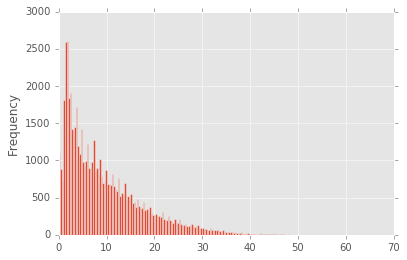

In [21]:
# Convert categorical variables to integer
import random
offense_df = pd.read_csv('/Users/jostheim/workspace/kaggle/src/nfl/bug_report.csv', index_col=0)
offense_df = offense_df[offense_df['dk_fpts'] >= 0]
filtered_offense_df = offense_df#.ix[random.sample(offense_df.index, 1000)]
filtered_offense_df.fillna(0.0)
le = preprocessing.LabelEncoder()
players_idx = le.fit_transform(filtered_offense_df['PLAYER'])
players = le.classes_
n_players = len(players)
print n_players, len(filtered_offense_df)
offense_df[offense_df['dk_fpts'] != 0]['dk_fpts'].plot(kind="hist", bins=200)
plt.show()

In [22]:
import scipy
with pm.Model() as model:
    hyper_alpha_sd = pm.Uniform('hyper_alpha_sd', lower=0, upper=50, transform=None)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10, transform=None)
    
    hyper_mu_sd = pm.Uniform('hyper_mu_sd', lower=0, upper=50, transform=None)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60, transform=None)
    
    alpha = pm.Gamma('alpha', mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_players)
    mu = pm.Gamma('mu', mu=hyper_mu_mu, sd=hyper_mu_sd, shape=n_players)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[players_idx], 
                                alpha=alpha[players_idx], 
                                observed=filtered_offense_df['dk_fpts'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[players_idx], 
                                 alpha=alpha[players_idx],
                                 shape=filtered_offense_df['PLAYER'].shape)
    
    start = pm.find_MAP(disp=True)
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(100000, step, start=start, progressbar=True)

KeyboardInterrupt: 

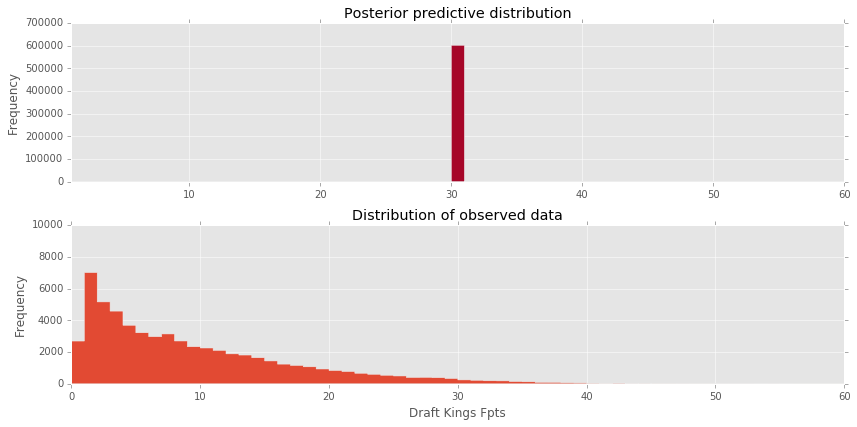

In [20]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred')[::1000].ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(offense_df['dk_fpts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Draft Kings Fpts')
_ = plt.ylim(0, 10000)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [ ]:
_ = pm.traceplot(hierarchical_trace[:], 
                 vars=['y_pred', 'mu', 'alpha', 'hyper_mu_mu','hyper_mu_sd','hyper_alpha_mu', 'hyper_alpha_sd'])